# Classificazione di Aspect e Opinion con ModernBERT su Laptop-ACOS

In [1]:
# Import delle librerie necessarie
import torch
import numpy as np
import random
import pandas as pd
import wandb
import os
import sys
import re
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForTokenClassification, get_linear_schedule_with_warmup, AutoModel
from torch.optim import AdamW
import torch.nn as nn
import bitsandbytes as bnb #per gpu invidia
from evaluate import load
from tqdm import tqdm
import pickle
from torch.amp import autocast, GradScaler # Per Mixed Precision
from sklearn.metrics import classification_report, f1_score, accuracy_score, precision_score, recall_score

print("Librerie caricate.")

# --- 1. CONFIGURAZIONE DEL DEVICE ---
# Se hai una GPU NVIDIA, userà 'cuda'. Se hai un Mac M1/M2, userà 'mps'. Altrimenti 'cpu'.
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f" GPU Trovata: {torch.cuda.get_device_name(0)}")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    print(" Acceleratore Apple Metal (MPS) Trovato")
else:
    device = torch.device("cpu")
    print(" Nessuna GPU trovata. L'addestramento sarà lento.")

Librerie caricate.
 GPU Trovata: NVIDIA GeForce RTX 4050 Laptop GPU


### Impostazioni per la riproducibilità 

In [2]:
def set_seed(seed_value=42):
    """Imposto i seed per la riproducibilità."""
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    if torch.cuda.is_available():
        # Imposto anche i seed per la GPU, se disponibile
        torch.cuda.manual_seed_all(seed_value)

# Esegui l'impostazione del seed
set_seed(42) 
print("Random seeds impostati su 42.")

Random seeds impostati su 42.


In [3]:

if wandb.run is not None:
    wandb.finish()

WANDB_ENTITY = "cristinatextmining"

# 1. Definizione degli Hyperparameters
config = {
    "learning_rate": 5e-5,
    "epochs": 40,
    "batch_size": 16,
    "model_name": "answerdotai/ModernBERT-base",
    "dataset": "Laptop-ACOS",
    "seed": 42,
    'patience': 2  # Per Early Stopping
}

# 2. Inizializzazione del Run
wandb.init(
    project="BigData-TextMining-ACOS",
    entity=WANDB_ENTITY,
    config=config,
    name=f"run_{config['model_name']}_{config['dataset']}"
)

print(f"W&B inizializzato per il progetto: {wandb.run.project}")


wandb: Currently logged in as: cristinatomaciello2001 (cristinatextmining) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


W&B inizializzato per il progetto: BigData-TextMining-ACOS


## PyTorch Dataset & DataLoader Construction

### Creazione di PyTorch Dataset e DataLoader
Questa cella si occupa di caricare i dati pre-processati e di "impacchettarli" nel formato esatto richiesto dalla nostra nuova architettura PyTorch personalizzata. Rappresenta un passaggio cruciale per replicare fedelmente il paper originale, permettendoci di gestire gli elementi impliciti.

Nello specifico, il codice esegue tre operazioni fondamentali:

1. **Caricamento dei DataFrame:** Legge i file `.pkl` (Train, Dev e Test per il dominio Laptop) che abbiamo precedentemente aggiornato. Questi file ora contengono le annotazioni binarie che indicano la presenza di aspetti o opinioni implicite.
2. **Definizione della Classe Custom `ACOSDataset`:** Questa è la modifica principale rispetto a una pipeline standard di HuggingFace. Invece di restituire solo i classici 3 tensori della Token Classification (`input_ids`, `attention_mask` e `labels` con i tag BIO), questa classe sovrascritta restituisce **5 tensori** per ogni frase. Vengono infatti estratti e passati al modello anche `implicit_aspect_labels` e `implicit_opinion_labels`. Questi tensori serviranno ad addestrare in parallelo le due teste di classificazione binaria sul token `[CLS]`.
3. **Configurazione dei DataLoader:** Crea gli iteratori di PyTorch che alimenteranno il modello durante l'addestramento e il test, processando blocchi (batch) di 16 frasi alla volta. I dati di training vengono rimescolati (`shuffle=True`) per stabilizzare l'apprendimento della rete.

In [4]:
cartella_dati = "data_allineati"

print("Caricamento dei dataset pre-processati aggiornati...")
df_train_align_laptop = pd.read_pickle(os.path.join(cartella_dati, "train_laptop_aligned.pkl"))
df_dev_align_laptop = pd.read_pickle(os.path.join(cartella_dati, "dev_laptop_aligned.pkl"))
df_test_align_laptop = pd.read_pickle(os.path.join(cartella_dati, "test_laptop_aligned.pkl"))

class ACOSDataset(Dataset):
    def __init__(self, df):
        self.input_ids = df['input_ids'].tolist()
        self.attention_mask = df['attention_mask'].tolist()
        self.labels = df['labels'].tolist()
        # Estraiamo le colonne per gli impliciti!
        self.implicit_aspect_label = df['implicit_aspect_label'].tolist()
        self.implicit_opinion_label = df['implicit_opinion_label'].tolist()

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return {
            'input_ids': torch.tensor(self.input_ids[idx], dtype=torch.long),
            'attention_mask': torch.tensor(self.attention_mask[idx], dtype=torch.long),
            'labels': torch.tensor(self.labels[idx], dtype=torch.long),
            # Passiamo le etichette al Dataloader
            'implicit_aspect_labels': torch.tensor(self.implicit_aspect_label[idx], dtype=torch.long),
            'implicit_opinion_labels': torch.tensor(self.implicit_opinion_label[idx], dtype=torch.long)
        }

# --- CREAZIONE DELLE ISTANZE ---

# Creiamo i dataset per il dominio Laptop
train_dataset_laptop = ACOSDataset(df_train_align_laptop)
dev_dataset_laptop = ACOSDataset(df_dev_align_laptop)
test_dataset_laptop = ACOSDataset(df_test_align_laptop)


# --- CONFIGURAZIONE DATALOADERS ---

BATCH_SIZE = 16 # Numero di frasi analizzate contemporaneamente

train_loader_laptop = DataLoader(train_dataset_laptop, batch_size=BATCH_SIZE, shuffle=True)
dev_loader_laptop = DataLoader(dev_dataset_laptop, batch_size=BATCH_SIZE)
test_loader_laptop = DataLoader(test_dataset_laptop, batch_size=BATCH_SIZE)



print(f"Dataset e DataLoaders creati con successo!")
print(f"Esempi nel set di Training LAPTOP: {len(train_dataset_laptop)}")


Caricamento dei dataset pre-processati aggiornati...
Dataset e DataLoaders creati con successo!
Esempi nel set di Training LAPTOP: 2934


### Architettura Multi-Task: ModernBERT ACOS Extractor

In questa cella abbandoniamo l'architettura standard di Token Classification per costruire un modello personalizzato in PyTorch, progettato per replicare fedelmente la logica di estrazione del paper ACOS originale.

Il problema dei modelli tradizionali è che falliscono quando un aspetto o un'opinione non sono scritti esplicitamente nel testo (elementi *Impliciti*). Per risolvere questa criticità, abbiamo progettato una rete **Multi-Task** composta da un "cervello" centrale (l'encoder ModernBERT) e **tre teste di classificazione indipendenti**:

1. **Testa di Token Classification (Estrazione Esplicita):** Analizza ogni singola parola della frase per assegnare i tag BIO (B-ASP, I-ASP, B-OPI, I-OPI, O), estraendo gli span di testo espliciti.
2. **Testa per Aspetti Impliciti (Classificazione Binaria):** Sfrutta il token speciale `[CLS]`, che racchiude il significato globale della frase, per prevedere matematicamente (Sì/No) se la recensione contiene un aspetto sottinteso.
3. **Testa per Opinioni Implicite (Classificazione Binaria):** Sfrutta sempre il token `[CLS]` per indovinare se c'è un'opinione sottintesa.

**La Loss Combinata (L'addestramento simultaneo)**
Il vero "motore" di questa classe è nella funzione `forward`. Durante l'addestramento, il modello calcola contemporaneamente tre errori separati (uno per l'estrazione e due per le previsioni binarie degli impliciti). Questi tre errori vengono **sommati in un'unica Loss globale**. In questo modo, la rete neurale viene forzata a imparare tutti i task simultaneamente, ottimizzando i pesi interni per comprendere a fondo sia ciò che è scritto, sia ciò che è sottinteso.

Infine, il modello viene caricato sulla GPU e accoppiato a un ottimizzatore **AdamW a 8-bit** (`bitsandbytes`) per massimizzare l'efficienza e prevenire l'esaurimento della memoria VRAM durante le epoche.

In [5]:
# Definiamo le 5 etichette: 0=O, 1=B-ASP, 2=I-ASP, 3=B-OPI, 4=I-OPI
NUM_LABELS = 5 

# --- 1. IL "CERVELLO" + 3 TESTE ---
class ModernBertACOS_Extractor(nn.Module):
    def __init__(self, model_name="answerdotai/ModernBERT-base", num_labels=5):
        super().__init__()
        # Carichiamo la "schiena" del modello (l'encoder base)
        self.bert = AutoModel.from_pretrained(model_name)
        hidden_size = self.bert.config.hidden_size
        
        # Testolina 1: Trova le parole scritte (Token Classification)
        self.token_classifier = nn.Linear(hidden_size, num_labels)
        
        # Testoline 2 e 3: Indovinano se ci sono impliciti (Classificazione Binaria)
        self.implicit_aspect_classifier = nn.Linear(hidden_size, 2)
        self.implicit_opinion_classifier = nn.Linear(hidden_size, 2)
        
    def forward(self, input_ids, attention_mask, labels=None, implicit_aspect_labels=None, implicit_opinion_labels=None):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        sequence_output = outputs.last_hidden_state 
        
        # Prendiamo il token [CLS] (posizione 0) per i classificatori binari
        cls_output = sequence_output[:, 0, :] 
        
        # Le tre testoline fanno le loro previsioni
        token_logits = self.token_classifier(sequence_output)
        imp_asp_logits = self.implicit_aspect_classifier(cls_output)
        imp_opi_logits = self.implicit_opinion_classifier(cls_output)
        
        loss = None
        # Calcolo della "Loss Combinata" durante il training
        if labels is not None and implicit_aspect_labels is not None and implicit_opinion_labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            
            # Loss 1: Token (ignorando il padding -100)
            active_loss = attention_mask.view(-1) == 1
            active_logits = token_logits.view(-1, 5)[active_loss]
            active_labels = labels.view(-1)[active_loss]
            loss_token = loss_fct(active_logits, active_labels)
            
            # Loss 2 & 3: Impliciti
            loss_asp = loss_fct(imp_asp_logits, implicit_aspect_labels)
            loss_opi = loss_fct(imp_opi_logits, implicit_opinion_labels)
            
            # Sommiamo gli errori in modo che impari tutto insieme!
            loss = loss_token + loss_asp + loss_opi
            
        return {
            "loss": loss, 
            "token_logits": token_logits, 
            "imp_asp_logits": imp_asp_logits, 
            "imp_opi_logits": imp_opi_logits
        }

print("Scaricamento e configurazione della nuova architettura Multi-Task ModernBERT...")

# Inizializziamo il nostro modello custom invece di AutoModelForTokenClassification
model_step1 = ModernBertACOS_Extractor(num_labels=NUM_LABELS)

# Spostiamo il modello sul dispositivo di calcolo (GPU/MPS/CPU)
model_step1.to(device)

# --- 2. CONFIGURAZIONE DELL'OTTIMIZZATORE E DELLA LOSS ---

# Manteniamo la tua ottima scelta di usare l'optimizer a 8-bit per non saturare la memoria!
optimizer = bnb.optim.AdamW8bit(model_step1.parameters(), lr=5e-5)



print("\n" + "="*50)
print("MODELLO MULTI-TASK PRONTO PER IL TRAINING")
print("="*50)
print(f"Architettura: ModernBERT-base (Custom ACOS Extractor)")
print(f"Task: Token Classification + 2x Binary Classification (Impliciti)")
print(f"Numero di Classi Token: {NUM_LABELS}")
print(f"Optimizer: AdamW 8-bit (lr=5e-5)")
print(f"Loss Function: Loss Combinata (calcolata internamente)")

Scaricamento e configurazione della nuova architettura Multi-Task ModernBERT...


Loading weights:   0%|          | 0/134 [00:00<?, ?it/s]

ModernBertModel LOAD REPORT from: answerdotai/ModernBERT-base
Key               | Status     |  | 
------------------+------------+--+-
head.dense.weight | UNEXPECTED |  | 
head.norm.weight  | UNEXPECTED |  | 
decoder.bias      | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.



MODELLO MULTI-TASK PRONTO PER IL TRAINING
Architettura: ModernBERT-base (Custom ACOS Extractor)
Task: Token Classification + 2x Binary Classification (Impliciti)
Numero di Classi Token: 5
Optimizer: AdamW 8-bit (lr=5e-5)
Loss Function: Loss Combinata (calcolata internamente)


In [6]:
# --- 1. CONFIGURAZIONE AVANZATA MEMORIA E WANDB ---
print("Attivazione Ottimizzazioni di Memoria...")

# Gradient Checkpointing: si applica all'encoder interno (BERT) della nostra classe custom
model_step1.bert.gradient_checkpointing_enable()

accumulation_steps = wandb.config.get('accumulation_steps', 4) 
patience = wandb.config.get('patience', 2)
epochs = wandb.config.get('epochs', 40)
lr = wandb.config.get('learning_rate', 5e-5)
patience_counter = 0

# Optimizer a 8-bit
optimizer = bnb.optim.AdamW8bit(model_step1.parameters(), lr=lr)

# Scaler per Mixed Precision (FP16)
scaler = GradScaler() 

total_steps = (len(train_loader_laptop) // accumulation_steps) * epochs
scheduler = get_linear_schedule_with_warmup(
    optimizer, 
    num_warmup_steps=0, 
    num_training_steps=total_steps
)

# --- 2. FUNZIONI DI SUPPORTO OTTIMIZZATE (MULTI-TASK) ---

def evaluate_model_multitask(model, data_loader, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            imp_asp_labels = batch['implicit_aspect_labels'].to(device)
            imp_opi_labels = batch['implicit_opinion_labels'].to(device)
            
            # Usiamo autocast in valutazione per risparmiare memoria
            with torch.amp.autocast(device_type='cuda' if torch.cuda.is_available() else 'cpu'):
                outputs = model(
                    input_ids=input_ids, 
                    attention_mask=attention_mask, 
                    labels=labels,
                    implicit_aspect_labels=imp_asp_labels,
                    implicit_opinion_labels=imp_opi_labels
                )
            
            total_loss += outputs['loss'].item()
    return total_loss / len(data_loader)

def train_epoch_multitask(model, data_loader, optimizer, scheduler, device, epoch_idx, scaler, accumulation_steps):
    model.train()
    total_loss = 0
    optimizer.zero_grad() # Reset iniziale
    
    loop = tqdm(data_loader, leave=True)
    
    for i, batch in enumerate(loop):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        imp_asp_labels = batch['implicit_aspect_labels'].to(device)
        imp_opi_labels = batch['implicit_opinion_labels'].to(device)
        
        # A. Mixed Precision Forward Pass (FP16)
        with torch.amp.autocast(device_type='cuda' if torch.cuda.is_available() else 'cpu'):
            outputs = model(
                input_ids=input_ids, 
                attention_mask=attention_mask, 
                labels=labels,
                implicit_aspect_labels=imp_asp_labels,
                implicit_opinion_labels=imp_opi_labels
            )
            # Normalizziamo la loss per l'accumulo dei gradienti
            loss = outputs['loss'] / accumulation_steps 
        
        # B. Backward Pass con Scaler (Evita underflow/overflow dell'FP16)
        scaler.scale(loss).backward()
        
        # C. Update Pesi ogni 'accumulation_steps'
        if (i + 1) % accumulation_steps == 0 or (i + 1) == len(data_loader):
            scaler.step(optimizer)
            scaler.update()
            scheduler.step()
            optimizer.zero_grad()
        
        total_loss += loss.item() * accumulation_steps
        wandb.log({"batch_loss": loss.item() * accumulation_steps})
        loop.set_description(f"Epoca {epoch_idx + 1}")
        loop.set_postfix(loss=loss.item() * accumulation_steps)

    return total_loss / len(data_loader)

# --- 3. CICLO DI ADDESTRAMENTO ---

print(f"\nTraining Multi-Task su LAPTOP: {epochs} epoche | Device: {device}")
print(f"Accumulo Gradienti: ogni {accumulation_steps} step | FP16: Attivato")

best_valid_loss_laptop = float('inf')
output_dir = "./best_multitask_extractor_laptop"

for epoch in range(epochs):
    print(f"\n--- Epoca {epoch+1}/{epochs} ---")
    
    # 1. Training
    train_loss_laptop = train_epoch_multitask(model_step1, train_loader_laptop, optimizer, scheduler, device, epoch, scaler, accumulation_steps)
    
    # 2. Validazione
    valid_loss_laptop = evaluate_model_multitask(model_step1, dev_loader_laptop, device)
    
    # Pulizia spietata della cache della GPU a fine epoca!
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    
    print(f"Train Loss: {train_loss_laptop:.4f} | Valid Loss: {valid_loss_laptop:.4f}")
    
    # 3. Log metriche epoca su W&B
    wandb.log({
        "epoch": epoch + 1,
        "train_loss_epoch": train_loss_laptop,
        "valid_loss_epoch": valid_loss_laptop
    })
    
    # --- LOGICA EARLY STOPPING & CHECKPOINT ---
    
    if valid_loss_laptop < best_valid_loss_laptop:
        best_valid_loss_laptop = valid_loss_laptop
        patience_counter = 0  
        
        print(f"Miglior modello trovato (Loss: {best_valid_loss_laptop:.4f})")
        
        os.makedirs(output_dir, exist_ok=True)
        # Salvataggio Custom per l'architettura Multi-Task
        torch.save(model_step1.state_dict(), os.path.join(output_dir, "pytorch_model.bin"))
        
    else:
        patience_counter += 1  
        print(f"Nessun miglioramento. Patience: {patience_counter}/{patience}")
        
        if patience_counter >= patience:
            print(f"\nEARLY STOPPING ATTIVATO! Interruzione all'epoca {epoch+1}.")
            break 

print("\nFine Addestramento Multi-Task.")
wandb.finish()

Attivazione Ottimizzazioni di Memoria...

Training Multi-Task su LAPTOP: 40 epoche | Device: cuda
Accumulo Gradienti: ogni 4 step | FP16: Attivato

--- Epoca 1/40 ---


Epoca 1:   2%|▏         | 3/184 [00:01<00:53,  3.40it/s, loss=3.37]/home/al3th3ia/Scrivania/Cristina/venv/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:192: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(
Epoca 1: 100%|██████████| 184/184 [00:38<00:00,  4.77it/s, loss=1.38]


Train Loss: 1.9724 | Valid Loss: 1.4677
Miglior modello trovato (Loss: 1.4677)

--- Epoca 2/40 ---


Epoca 2: 100%|██████████| 184/184 [00:39<00:00,  4.63it/s, loss=1.47] 


Train Loss: 1.2984 | Valid Loss: 1.0846
Miglior modello trovato (Loss: 1.0846)

--- Epoca 3/40 ---


Epoca 3: 100%|██████████| 184/184 [00:40<00:00,  4.59it/s, loss=1.14] 


Train Loss: 0.8684 | Valid Loss: 1.0093
Miglior modello trovato (Loss: 1.0093)

--- Epoca 4/40 ---


Epoca 4: 100%|██████████| 184/184 [00:40<00:00,  4.59it/s, loss=1.5]  


Train Loss: 0.5553 | Valid Loss: 0.9949
Miglior modello trovato (Loss: 0.9949)

--- Epoca 5/40 ---


Epoca 5: 100%|██████████| 184/184 [00:40<00:00,  4.58it/s, loss=0.277]


Train Loss: 0.2954 | Valid Loss: 1.0662
Nessun miglioramento. Patience: 1/2

--- Epoca 6/40 ---


Epoca 6: 100%|██████████| 184/184 [00:40<00:00,  4.59it/s, loss=0.0911]


Train Loss: 0.1583 | Valid Loss: 1.3611
Nessun miglioramento. Patience: 2/2

EARLY STOPPING ATTIVATO! Interruzione all'epoca 6.

Fine Addestramento Multi-Task.


batch_loss,███▇▇▇▇▇▇▆▄▅▅▅▆▅▅▃▃▄▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▂▄▅▇█
train_loss_epoch,█▅▄▃▂▁
valid_loss_epoch,█▂▁▁▂▆
batch_loss,0.09107
epoch,6
train_loss_epoch,0.15831
valid_loss_epoch,1.36106


In [7]:
# --- A. CARICAMENTO DEL "CAMPIONE" MULTI-TASK ---
print("Caricamento del modello Multi-Task migliore...")

# 1. Inizializziamo la nostra architettura custom
model_step1 = ModernBertACOS_Extractor(num_labels=5)

# 2. Carichiamo i pesi salvati del miglior modello (solo i pesi, non l'intero oggetto)
model_path = "./best_multitask_extractor_laptop/pytorch_model.bin"
model_step1.load_state_dict(torch.load(model_path, map_location=device, weights_only=True))

model_step1.to(device)
model_step1.eval() # Modalità esame (spegne dropout)

# --- B. PREPARAZIONE METRICHE ---
# Carichiamo la metrica seqeval (standard per NER/ABSA)
metric = load("seqeval")

# Mappa per decodificare i numeri in etichette
id2label = {0: 'O', 1: 'B-ASP', 2: 'I-ASP', 3: 'B-OPI', 4: 'I-OPI'}

print("\nInizio Test Multi-Task sul Dataset Laptop...")

# --- C. CICLO DI PREVISIONE ---
predictions_tokens = []
true_labels_tokens = []

# Liste per salvare le predizioni binarie (Impliciti)
true_imp_asp, pred_imp_asp = [], []
true_imp_opi, pred_imp_opi = [], []

with torch.no_grad():
    for batch in tqdm(test_loader_laptop, desc="Test LAPTOP"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        imp_asp_labels = batch['implicit_aspect_labels'].to(device)
        imp_opi_labels = batch['implicit_opinion_labels'].to(device)

        # 1. Il modello fa le sue 3 predizioni contemporaneamente
        with torch.amp.autocast(device_type='cuda' if torch.cuda.is_available() else 'cpu'):
            outputs = model_step1(input_ids, attention_mask=attention_mask)
        
        # 2. Estraiamo i risultati dalle 3 testoline
        token_preds = torch.argmax(outputs['token_logits'], dim=-1)
        asp_preds = torch.argmax(outputs['imp_asp_logits'], dim=-1)
        opi_preds = torch.argmax(outputs['imp_opi_logits'], dim=-1)
        
        # Salviamo i risultati binari
        true_imp_asp.extend(imp_asp_labels.cpu().tolist())
        pred_imp_asp.extend(asp_preds.cpu().tolist())
        
        true_imp_opi.extend(imp_opi_labels.cpu().tolist())
        pred_imp_opi.extend(opi_preds.cpu().tolist())

        # 3. Convertiamo i numeri in etichette BIO (pulendo il padding)
        for i in range(len(labels)):
            true_label_row = []
            pred_label_row = []
            
            for j in range(len(labels[i])):
                # Ignoriamo i token di padding (dove attention_mask è 0 o la label è -100)
                if labels[i][j] != -100 and attention_mask[i][j] == 1: 
                    true_label_row.append(id2label[labels[i][j].item()])
                    pred_label_row.append(id2label[token_preds[i][j].item()])
            
            true_labels_tokens.append(true_label_row)
            predictions_tokens.append(pred_label_row)

# --- D. CALCOLO E STAMPA RISULTATI ---
results_seq = metric.compute(predictions=predictions_tokens, references=true_labels_tokens)

print("\n" + "="*60)
print("RISULTATI FINALI: TOKEN CLASSIFICATION (Parole Esplicite)")
print("="*60)

print(f"Overall Precision: {results_seq['overall_precision']:.4f}")
print(f"Overall Recall:    {results_seq['overall_recall']:.4f}")
print(f"Overall F1-Score:  {results_seq['overall_f1']:.4f}")

print("\nDettaglio per Classe (Quello che conta per il paper):")
print("-" * 50)
for key in results_seq.keys():
    if key in ['ASP', 'OPI']: 
        print(f"   {key}:")
        print(f"   Precision: {results_seq[key]['precision']:.4f}")
        print(f"   Recall:    {results_seq[key]['recall']:.4f}")
        print(f"   F1-Score:  {results_seq[key]['f1']:.4f}")
        print(f"   Support:   {results_seq[key]['number']}") 

print("\n" + "="*60)
print("RISULTATI FINALI: IDENTIFICAZIONE IMPLICITI (NULL)")
print("="*60)

# Metriche per Aspetti Impliciti
acc_asp = accuracy_score(true_imp_asp, pred_imp_asp)
print(f"🔹 Accuratezza Aspetti Impliciti: {acc_asp:.4f}")
print(classification_report(true_imp_asp, pred_imp_asp, target_names=["Esplicito (0)", "Implicito (1)"], zero_division=0))

print("-" * 50)

# Metriche per Opinioni Implicite
acc_opi = accuracy_score(true_imp_opi, pred_imp_opi)
print(f"🔹 Accuratezza Opinioni Implicite: {acc_opi:.4f}")
print(classification_report(true_imp_opi, pred_imp_opi, target_names=["Esplicito (0)", "Implicito (1)"], zero_division=0))
print("="*60)

Caricamento del modello Multi-Task migliore...


Loading weights:   0%|          | 0/134 [00:00<?, ?it/s]

ModernBertModel LOAD REPORT from: answerdotai/ModernBERT-base
Key               | Status     |  | 
------------------+------------+--+-
head.dense.weight | UNEXPECTED |  | 
head.norm.weight  | UNEXPECTED |  | 
decoder.bias      | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.



Inizio Test Multi-Task sul Dataset Laptop...


Test LAPTOP: 100%|██████████| 51/51 [00:06<00:00,  8.29it/s]



RISULTATI FINALI: TOKEN CLASSIFICATION (Parole Esplicite)
Overall Precision: 0.6703
Overall Recall:    0.6588
Overall F1-Score:  0.6645

Dettaglio per Classe (Quello che conta per il paper):
--------------------------------------------------
   ASP:
   Precision: 0.5979
   Recall:    0.6322
   F1-Score:  0.6145
   Support:   802
   OPI:
   Precision: 0.7578
   Recall:    0.6865
   F1-Score:  0.7204
   Support:   775

RISULTATI FINALI: IDENTIFICAZIONE IMPLICITI (NULL)
🔹 Accuratezza Aspetti Impliciti: 0.8897
               precision    recall  f1-score   support

Esplicito (0)       0.92      0.94      0.93       627
Implicito (1)       0.78      0.74      0.76       189

     accuracy                           0.89       816
    macro avg       0.85      0.84      0.84       816
 weighted avg       0.89      0.89      0.89       816

--------------------------------------------------
🔹 Accuratezza Opinioni Implicite: 0.8174
               precision    recall  f1-score   support

Esplic

## Classificatore Category-Sentiment (Extract-Classify-ACOS)

Implementiamo il **secondo stadio** dell'architettura proposta nel paper. Dopo aver estratto gli Aspetti e le Opinioni nello Step 1, ora dobbiamo capire a quale Categoria appartengono e qual è il loro Sentiment.

Il codice di preparazione è diviso in tre componenti fondamentali:

 1. Il Dataset PyTorch (`ACOSPairDataset`)

 2. L'Architettura Custom (`ModernBertACOSClassifier`)

 3. Inizializzazione e DataLoaders

In [3]:
class ACOSPairDataset(Dataset):
    def __init__(self, df, tokenizer, max_length=128):
        self.df = df
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        text = row['review_text']
        
        # Gli span sono già corretti con il +1 per il [CLS]!
        a_span = row['aspect_span']
        o_span = row['opinion_span']

        # Tokenizzazione (ModernBERT usa il token [CLS] in automatico)
        encoding = self.tokenizer(
            text,
            padding='max_length',
            truncation=True,
            max_length=self.max_length,
            return_tensors='pt'
        )

        labels = torch.tensor(row['labels'], dtype=torch.long)

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'aspect_span': torch.tensor(a_span),
            'opinion_span': torch.tensor(o_span),
            'labels': labels
        }

### 2. L'Architettura Custom (`ModernBertACOSClassifier`)
Questa è la vera "magia" matematica del paper, tradotta in codice:
* **Il Corpo (Backbone):** Invece di partire da zero, carichiamo il *corpo* del modello che hai già addestrato nello Step 1 (`best_model_laptop`). In questo modo, la rete conosce già il dominio tecnico dei computer!
* **Span Pooling:** Il modello estrae i vettori (hidden states) corrispondenti alle parole dell'Aspetto e dell'Opinione e ne calcola la media. Se un elemento è implicito (`-1`), pesca automaticamente il vettore globale del token `[CLS]`.
* **Feature Fusion:** Concatena il vettore dell'aspetto ($u_a$) e dell'opinione ($u_o$) in un unico grande vettore di dimensione 1536.
* **Le 121 Teste (Multiple Multi-class):** Passa questo vettore in 121 classificatori lineari paralleli. Ognuno di essi deciderà se per la *sua* categoria la coppia è `Positive (0)`, `Negative (1)`, `Neutral (2)` o `Invalid (3)`.

In [ ]:
class ModernBertACOSClassifier(nn.Module):
    def __init__(self, path_to_best_model, num_categories):
        super(ModernBertACOSClassifier, self).__init__()
        
        # Carichiamo SOLO IL CORPO dal tuo modello dello Step 1
        self.modernbert = AutoModel.from_pretrained(path_to_best_model)
        hidden_size = self.modernbert.config.hidden_size # 768
        
        # Le 121 teste (ognuna prende il vettore concatenato 1536 e sputa 4 classi)
        self.heads = nn.ModuleList([
            nn.Linear(hidden_size * 2, 4) for _ in range(num_categories)
        ])
        
        self.dropout = nn.Dropout(0.1)

    def forward(self, input_ids, attention_mask, aspect_spans, opinion_spans):
        outputs = self.modernbert(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden_state = outputs.last_hidden_state # [Batch, Seq_Len, 768]
        
        batch_size = last_hidden_state.size(0)
        u_a_list, u_o_list = [], []

        for i in range(batch_size):
            # Pooling Aspetto
            a_start, a_end = aspect_spans[i]
            if a_start == -1: 
                u_a = last_hidden_state[i, 0, :] # Token [CLS]
            else:
                u_a = last_hidden_state[i, a_start:a_end, :].mean(dim=0)
            
            # Pooling Opinione
            o_start, o_end = opinion_spans[i]
            if o_start == -1: 
                u_o = last_hidden_state[i, 0, :] # Token [CLS]
            else:
                u_o = last_hidden_state[i, o_start:o_end, :].mean(dim=0)
            
            u_a_list.append(u_a)
            u_o_list.append(u_o)

        # Concatenazione: [u_a ; u_o]
        combined_features = torch.cat((torch.stack(u_a_list), torch.stack(u_o_list)), dim=-1)
        combined_features = self.dropout(combined_features)

        # Passiamo il vettore nelle teste lineari
        logits = [head(combined_features) for head in self.heads]
        
        # Output: [Batch, 121, 4]
        return torch.stack(logits, dim=1)

### 3. Inizializzazione e DataLoaders
L'ultimo blocco carica fisicamente i file salvati dalla nostra "Fabbrica dei Dati", istanzia i `Dataset`, e crea i `DataLoader` (con batch size = 16) per "nutrire" la GPU in modo efficiente durante l'addestramento. Infine, sposta il modello sulla scheda video (CUDA) pronto per il training.

In [ ]:
# 1. Carichiamo la lista delle categorie salvata prima
with open("data_coppie/laptop_categories.pkl", "rb") as f:
    category_list = pickle.load(f)
num_categories = len(category_list) # 121

# 2. Carichiamo i DataFrame di Train e Dev
df_train = pd.read_pickle("data_coppie/train_laptop_pairs.pkl")
df_dev = pd.read_pickle("data_coppie/dev_laptop_pairs.pkl")
df_test = pd.read_pickle("data_coppie/test_laptop_pairs.pkl") # <-- AGGIUNTO!

# 3. Inizializziamo il Tokenizer e i Dataset
tokenizer = AutoTokenizer.from_pretrained("answerdotai/ModernBERT-base")
train_dataset = ACOSPairDataset(df_train, tokenizer)
dev_dataset = ACOSPairDataset(df_dev, tokenizer)
test_dataset = ACOSPairDataset(df_test, tokenizer) # <-- AGGIUNTO!

# 4. Creiamo i DataLoader (Batch size 16 è un buon compromesso tra velocità e VRAM)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(dev_dataset, batch_size=16)
test_loader = DataLoader(test_dataset, batch_size=16) # <-- AGGIUNTO!

# 5. Inizializziamo il Modello usando i pesi dello Step 1!
model = ModernBertACOSClassifier("./best_model_laptop", num_categories)
model.to(device)

print(f"Modello inizializzato! Categorie: {num_categories} | Device: {device}")

Loading weights:   0%|          | 0/134 [00:00<?, ?it/s]

ModernBertModel LOAD REPORT from: ./best_model_laptop
Key               | Status     |  | 
------------------+------------+--+-
head.dense.weight | UNEXPECTED |  | 
classifier.bias   | UNEXPECTED |  | 
head.norm.weight  | UNEXPECTED |  | 
classifier.weight | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Modello inizializzato! Categorie: 121 | Device: cpu


## WANDB per il Monitoraggio dello Step 2

In [6]:
# Chiudiamo per sicurezza qualsiasi run precedente rimasta aperta nello stesso notebook
if wandb.run is not None:
    wandb.finish()

WANDB_ENTITY = "cristinatextmining"

# 1. Definizione degli Hyperparameters per lo STEP 2
config_step2 = {
    "learning_rate": 2e-5, # Solitamente per lo Step 2 un LR leggermente più basso è meglio (es. 2e-5)
    "epochs": 40,
    "batch_size": 16,
    "accumulation_steps": 4, # Aggiunto per il tuo training loop ottimizzato!
    "model_name": "answerdotai/ModernBERT-base",
    "dataset": "Laptop-ACOS", 
    "seed": 42,
    "patience": 2  # Per Early Stopping
}

# 2. Inizializzazione del Run per lo Step 2
wandb.init(
    project="BigData-TextMining-ACOS",
    entity=WANDB_ENTITY,
    config=config_step2,
    # Aggiungiamo "Step2_Class" al nome per distinguerlo dallo Step 1
    name=f"Step2_Class_{config_step2['model_name']}_{config_step2['dataset']}" 
)

print(f" W&B inizializzato per il progetto: {wandb.run.project}")
print(f"Nome della Run attuale: {wandb.run.name}")

wandb: Currently logged in as: cristinatomaciello2001 (cristinatextmining) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


 W&B inizializzato per il progetto: BigData-TextMining-ACOS
Nome della Run attuale: Step2_Class_answerdotai/ModernBERT-base_Laptop-ACOS


## Training e valutazione del modello su Sentiment e Categoria

In [ ]:
# --- 1. CONFIGURAZIONE AVANZATA MEMORIA ---

# Gradient Checkpointing: abilitato SOLO sul corpo di ModernBERT
model.modernbert.gradient_checkpointing_enable()

# Parametri per simulare un batch size maggiore
accumulation_steps = config_step2.get('accumulation_steps', 4) 
patience = config_step2.get('patience', 2)
patience_counter = 0

# Ottimizzatore AdamW a 8-bit
optimizer = bnb.optim.AdamW8bit(
    model.parameters(), 
    lr=config_step2['learning_rate']
)

# Scaler per Mixed Precision (fondamentale per evitare l'OOM)
scaler = GradScaler() 

# La Loss per le 121 teste
weights = torch.tensor([150.0, 400.0, 100.0, 1.0]).to(device)
criterion = nn.CrossEntropyLoss(weight=weights)

# Calcolo degli step totali per lo scheduler
total_steps = (len(train_loader) // accumulation_steps) * config_step2['epochs']
scheduler = get_linear_schedule_with_warmup(
    optimizer, 
    num_warmup_steps=0, 
    num_training_steps=total_steps
)

# --- 2. FUNZIONI DI SUPPORTO OTTIMIZZATE (STEP 2) ---

def evaluate_model_step2(model, data_loader, criterion, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            aspect_span = batch['aspect_span'].to(device)
            opinion_span = batch['opinion_span'].to(device)
            labels = batch['labels'].to(device)
            
            # Usiamo autocast anche in valutazione
            with autocast(device_type='cuda'):
                logits = model(input_ids=input_ids, attention_mask=attention_mask, 
                               aspect_spans=aspect_span, opinion_spans=opinion_span)
                
                # Calcolo Loss su tutte le teste
                loss = criterion(logits.view(-1, 4), labels.view(-1))
            
            total_loss += loss.item()
            
    return total_loss / len(data_loader)

def train_epoch_step2(model, data_loader, optimizer, scheduler, criterion, device, epoch_idx, scaler, accumulation_steps):
    model.train()
    total_loss = 0
    optimizer.zero_grad() # Reset iniziale
    
    loop = tqdm(data_loader, leave=True)
    
    for i, batch in enumerate(loop):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        aspect_span = batch['aspect_span'].to(device)
        opinion_span = batch['opinion_span'].to(device)
        labels = batch['labels'].to(device)
        
        # A. Mixed Precision Forward Pass
        with autocast(device_type='cuda'):
            logits = model(input_ids=input_ids, attention_mask=attention_mask, 
                           aspect_spans=aspect_span, opinion_spans=opinion_span)
            
            loss = criterion(logits.view(-1, 4), labels.view(-1))
            # Dividiamo la loss per gli step di accumulo
            loss = loss / accumulation_steps 
        
        # B. Backward Pass con Scaler
        scaler.scale(loss).backward()
        
        # C. Update Pesi ogni 'accumulation_steps'
        if (i + 1) % accumulation_steps == 0 or (i + 1) == len(data_loader):
            scaler.step(optimizer)
            scaler.update()
            scheduler.step()
            optimizer.zero_grad()
        
        # Ricalcoliamo il valore reale della loss per i log
        real_loss = loss.item() * accumulation_steps
        total_loss += real_loss
        
        wandb.log({"batch_loss": real_loss})
        loop.set_description(f"Epoca {epoch_idx + 1}")
        loop.set_postfix(loss=real_loss)

    return total_loss / len(data_loader)

# --- 3. CICLO DI ADDESTRAMENTO ---

print(f"Training STEP 2 su LAPTOP: {config_step2['epochs']} epoche | Device: {device}")
print(f"Accumulo Gradienti ogni {accumulation_steps} step | FP16 Attivato")

best_valid_loss_laptop = float('inf')

for epoch in range(config_step2['epochs']):
    print(f"\n--- Epoca {epoch+1}/{config_step2['epochs']} ---")
    
    # 1. Training
    train_loss_laptop = train_epoch_step2(
        model, train_loader, optimizer, scheduler, criterion, 
        device, epoch, scaler, accumulation_steps
    )
    
    # 2. Validazione
    valid_loss_laptop = evaluate_model_step2(model, val_loader, criterion, device)
    
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    
    print(f"Train Loss: {train_loss_laptop:.4f} | Valid Loss: {valid_loss_laptop:.4f}")
    
    # 3. Log metriche epoca su W&B
    wandb.log({
        "epoch": epoch + 1,
        "train_loss_epoch": train_loss_laptop,
        "valid_loss_epoch": valid_loss_laptop
    })
    
    # --- LOGICA EARLY STOPPING & CHECKPOINT ---
    
    if valid_loss_laptop < best_valid_loss_laptop:
        best_valid_loss_laptop = valid_loss_laptop
        patience_counter = 0  
        
        print(f"Miglior modello trovato (Loss: {best_valid_loss_laptop:.4f})! Salvataggio...")
        
        # Salvataggio custom model (Solo i pesi)
        save_dir = "./best_classifier_laptop"
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
            
        torch.save(model.state_dict(), os.path.join(save_dir, "pytorch_model.bin"))
        
    else:
        patience_counter += 1  
        print(f"Nessun miglioramento. Patience: {patience_counter}/{patience}")
        
        if patience_counter >= patience:
            print(f"\nEARLY STOPPING ATTIVATO! Interruzione all'epoca {epoch+1}.")
            break 

print("\nFine Addestramento Step 2.")
wandb.finish()

Training STEP 2 su LAPTOP: 40 epoche | Device: cuda
Accumulo Gradienti ogni 4 step | FP16 Attivato

--- Epoca 1/40 ---


Epoca 1:   1%|          | 3/342 [00:00<01:37,  3.49it/s, loss=1.73]/home/al3th3ia/Scrivania/Cristina/venv/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:192: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(
Epoca 1: 100%|██████████| 342/342 [01:17<00:00,  4.40it/s, loss=0.588]


Train Loss: 1.0917 | Valid Loss: 0.8533
Miglior modello trovato (Loss: 0.8533)! Salvataggio...

--- Epoca 2/40 ---


Epoca 2: 100%|██████████| 342/342 [01:19<00:00,  4.33it/s, loss=0.596]


Train Loss: 0.7580 | Valid Loss: 0.7928
Miglior modello trovato (Loss: 0.7928)! Salvataggio...

--- Epoca 3/40 ---


Epoca 3: 100%|██████████| 342/342 [01:19<00:00,  4.32it/s, loss=0.575]


Train Loss: 0.6127 | Valid Loss: 0.7131
Miglior modello trovato (Loss: 0.7131)! Salvataggio...

--- Epoca 4/40 ---


Epoca 4: 100%|██████████| 342/342 [01:18<00:00,  4.38it/s, loss=0.417]


Train Loss: 0.4775 | Valid Loss: 0.6727
Miglior modello trovato (Loss: 0.6727)! Salvataggio...

--- Epoca 5/40 ---


Epoca 5: 100%|██████████| 342/342 [01:20<00:00,  4.27it/s, loss=0.31] 


Train Loss: 0.3668 | Valid Loss: 0.6500
Miglior modello trovato (Loss: 0.6500)! Salvataggio...

--- Epoca 6/40 ---


Epoca 6: 100%|██████████| 342/342 [01:18<00:00,  4.35it/s, loss=0.22] 


Train Loss: 0.2960 | Valid Loss: 0.6262
Miglior modello trovato (Loss: 0.6262)! Salvataggio...

--- Epoca 7/40 ---


Epoca 7: 100%|██████████| 342/342 [01:19<00:00,  4.32it/s, loss=0.165]


Train Loss: 0.2228 | Valid Loss: 0.6176
Miglior modello trovato (Loss: 0.6176)! Salvataggio...

--- Epoca 8/40 ---


Epoca 8: 100%|██████████| 342/342 [01:22<00:00,  4.16it/s, loss=0.185]


Train Loss: 0.1747 | Valid Loss: 0.6212
Nessun miglioramento. Patience: 1/2

--- Epoca 9/40 ---


Epoca 9: 100%|██████████| 342/342 [01:19<00:00,  4.28it/s, loss=0.286] 


Train Loss: 0.1428 | Valid Loss: 0.6527
Nessun miglioramento. Patience: 2/2

EARLY STOPPING ATTIVATO! Interruzione all'epoca 9.

Fine Addestramento Step 2.


batch_loss,▇▆▅█▄▄▄▃▃▃▄▄▃▃▄▃▃▃▃▂▂▂▂▂▂▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▂▃▄▅▅▆▇█
train_loss_epoch,█▆▄▃▃▂▂▁▁
valid_loss_epoch,█▆▄▃▂▁▁▁▂
batch_loss,0.28619
epoch,9
train_loss_epoch,0.14278
valid_loss_epoch,0.65272


## Test su sentiment e categoria

In [ ]:
# Chiudiamo run appese
if wandb.run is not None:
    wandb.finish()

WANDB_ENTITY = "cristinatextmining"

wandb.init(
    project="BigData-TextMining-ACOS",
    entity=WANDB_ENTITY,
    # Chiamo la run con il prefisso "TEST_"
    name=f"TEST_Step2_{config_step2['model_name']}_{config_step2['dataset']}",
    job_type="test"
)

# --- 1. PREPARAZIONE ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Avvio Test sul Device: {device}")

# Ricreiamo l'architettura del modello
num_categories = len(category_list)
model_test = ModernBertACOSClassifier("./best_model_laptop", num_categories)

# Carichiamo i pesi dello Step 2
model_path = "./best_classifier_laptop/pytorch_model.bin"
state_dict = torch.load(model_path, map_location=device)

# USIAMO STRICT=FALSE
missing_keys, unexpected_keys = model_test.load_state_dict(state_dict, strict=False)

print("\n--- CHECK CARICAMENTO PESI ---")
print(f"Chiavi Inaspettate (OK se sono dello Step 1): {len(unexpected_keys)}")
print(f"Chiavi Mancanti (PROBLEMA se sono 'heads'): {len(missing_keys)}")

# Verifica specifica sulle teste
heads_missing = [k for k in missing_keys if "heads" in k]
if heads_missing:
    print(f"ERRORE CRITICO: Le teste di classificazione non sono state caricate! {heads_missing[:5]}")
else:
    print("SUCCESS: Le teste di classificazione (Sentiment) sono state caricate correttamente.")
    
model_test.to(device)
model_test.eval()

# --- 2. ESTRAZIONE PROBABILITA'---
print("Estrazione di tutte le probabilità dal modello in corso (attendere)...")

all_probs_list = []
all_true_list = []

with torch.no_grad():
    for batch in test_loader: # (Usa test_loader_rest per i ristoranti!)
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        aspect_span = batch['aspect_span'].to(device)
        opinion_span = batch['opinion_span'].to(device)
        labels = batch['labels'].to(device) 
        
        with torch.amp.autocast(device_type='cuda'):
            logits = model_test(input_ids, attention_mask, aspect_span, opinion_span)
            
        # Trasformiamo i logits in probabilità e li portiamo su CPU per non intasarla
        probs = torch.softmax(logits, dim=-1).cpu() 
        
        all_probs_list.append(probs)
        all_true_list.append(labels.cpu())

# Uniamo tutti i batch in un unico grande blocco di memoria
all_probs = torch.cat(all_probs_list, dim=0) # Forma: [Tot_Frasi, 121, 4]
all_true = torch.cat(all_true_list, dim=0).numpy().flatten()


# --- 3. GRID SEARCH SUL THRESHOLD (OTTIMIZZATA PER MACRO F1) ---
print("\n🔍 Avvio Grid Search per la migliore Soglia (MACRO F1)...")

# SCENDIAMO FINO A 0.30! Diamo al modello la possibilità di essere meno sicuro.
thresholds_to_test = np.arange(0.40, 0.99, 0.02) 
best_micro_f1 = 0.0
best_macro_f1 = 0.0
best_threshold = 0.0
best_report = ""

target_names = ['Positive (0)', 'Negative (1)', 'Neutral (2)']
labels_to_eval = [0, 1, 2]

# INIZIO CICLO SILENZIOSO
for thresh in thresholds_to_test:
    valid_class_probs, valid_class_preds = torch.max(all_probs[:, :, :3], dim=-1)
    final_preds = torch.full_like(valid_class_preds, 3)
    
    mask = valid_class_probs > thresh
    final_preds[mask] = valid_class_preds[mask]
    
    preds_flat = final_preds.numpy().flatten()
    
    current_micro_f1 = f1_score(all_true, preds_flat, labels=labels_to_eval, average='micro')
    current_macro_f1 = f1_score(all_true, preds_flat, labels=labels_to_eval, average='macro')
    
    # ORA VINCE CHI ALZA IL MACRO F1!
    if current_macro_f1 > best_macro_f1:
        best_macro_f1 = current_macro_f1
        best_micro_f1 = current_micro_f1
        best_threshold = thresh
        best_report = classification_report(
            all_true, preds_flat, labels=labels_to_eval, 
            target_names=target_names, zero_division=0
        )

# --- 4. STAMPA DEI RISULTATI VINCITORI E LOG W&B ---
print(f"IL VINCITORE È... THRESHOLD A {best_threshold:.2f} ({(best_threshold*100):.0f}%)")

print("\n--- MIGLIOR CLASSIFICATION REPORT (Basato su Macro F1) ---")
print(best_report)
print(f"BEST MACRO F1-Score: {best_macro_f1:.4f}")
print(f"CORRISPONDENTE MICRO F1: {best_micro_f1:.4f}")
print("="*50)

# Salviamo su Weights & Biases
wandb.log({
    "best_test_micro_f1": best_micro_f1,
    "best_test_macro_f1": best_macro_f1,
    "optimal_threshold": best_threshold
})
wandb.finish()

Avvio Test sul Device: cuda


Loading weights:   0%|          | 0/134 [00:00<?, ?it/s]

ModernBertModel LOAD REPORT from: ./best_model_laptop
Key               | Status     |  | 
------------------+------------+--+-
classifier.bias   | UNEXPECTED |  | 
classifier.weight | UNEXPECTED |  | 
head.norm.weight  | UNEXPECTED |  | 
head.dense.weight | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.



--- CHECK CARICAMENTO PESI ---
Chiavi Inaspettate (OK se sono dello Step 1): 0
Chiavi Mancanti (PROBLEMA se sono 'heads'): 0
SUCCESS: Le teste di classificazione (Sentiment) sono state caricate correttamente.
Estrazione di tutte le probabilità dal modello in corso (attendere)...

🔍 Avvio Grid Search per la migliore Soglia (MACRO F1)...
IL VINCITORE È... THRESHOLD A 0.80 (80%)

--- MIGLIOR CLASSIFICATION REPORT (Basato su Macro F1) ---
              precision    recall  f1-score   support

Positive (0)       0.16      0.21      0.18       379
Negative (1)       0.27      0.05      0.08        65
 Neutral (2)       0.26      0.46      0.33       712

   micro avg       0.23      0.35      0.28      1156
   macro avg       0.23      0.24      0.20      1156
weighted avg       0.23      0.35      0.27      1156

BEST MACRO F1-Score: 0.1969
CORRISPONDENTE MICRO F1: 0.2795


best_test_macro_f1,▁
best_test_micro_f1,▁
optimal_threshold,▁
best_test_macro_f1,0.19692
best_test_micro_f1,0.27948
optimal_threshold,0.8


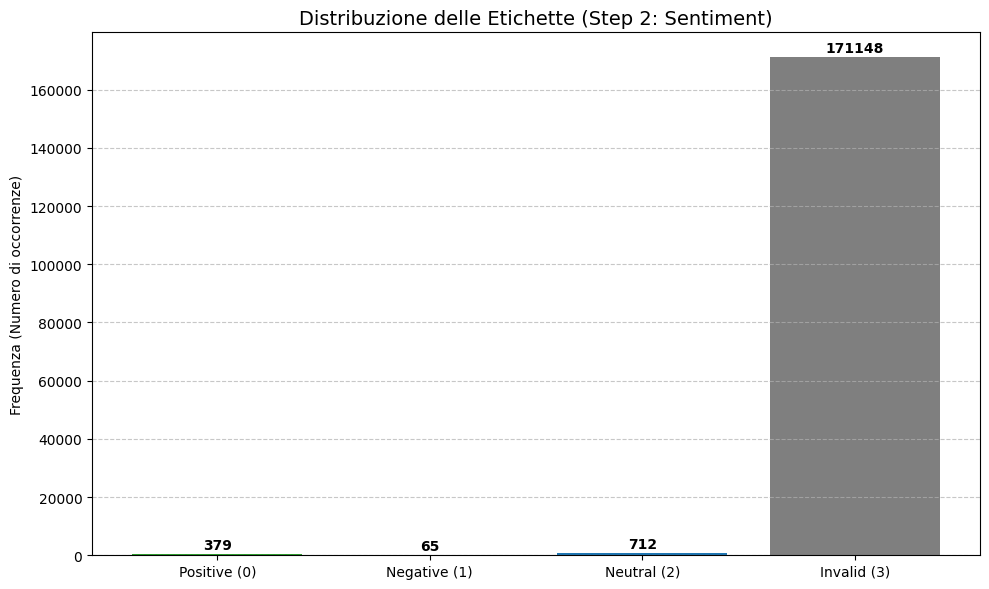

In [47]:
import matplotlib.pyplot as plt
url = "data_coppie/test_laptop_pairs.pkl"
df = pd.read_pickle(url)
df.sample(5)

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import ast

# 1. Estraiamo tutti i singoli valori dalle liste della colonna 'labels'
all_labels = []
for row in df['labels']:
    # Se i dati sono stringhe, usiamo ast.literal_eval per convertirli in liste
    if isinstance(row, str):
        l = ast.literal_eval(row)
    else:
        l = row
    all_labels.extend(l)

# 2. Contiamo le occorrenze di ogni classe
unique, counts = np.unique(all_labels, return_counts=True)
label_map = {0: 'Positive (0)', 1: 'Negative (1)', 2: 'Neutral (2)', 3: 'Invalid (3)'}
names = [label_map.get(x, f"Classe {x}") for x in unique]

# 3. Creazione del Grafico
plt.figure(figsize=(10, 6))
colors = ['#2ca02c', '#d62728', '#1f77b4', '#7f7f7f'] # Verde, Rosso, Blu, Grigio
bars = plt.bar(names, counts, color=colors[:len(names)])

# Aggiungiamo i valori numerici sopra ogni barra
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + (max(counts)*0.01), 
             int(yval), ha='center', fontweight='bold')

plt.title('Distribuzione delle Etichette (Step 2: Sentiment)', fontsize=14)
plt.ylabel('Frequenza (Numero di occorrenze)')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()